MLPの構築と学習

In [1]:
"""
手書き文字を判別するMLPを作成
"""
import torch
from torch import nn

net = nn.Sequential(
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 16),
    nn.ReLU(),
    nn.Linear(16, 10)
)

In [3]:
"""
手書き文字データセットの学習のコードの残り部分
"""
from torch import optim
from sklearn.datasets import load_digits
digits = load_digits()

X = digits.data
Y = digits.target

# NumPyのndarrayをPyTorchのTensorに変換
X = torch.tensor(X, dtype=torch.float32)
Y = torch.tensor(Y, dtype=torch.int64)

# ソフトマックスクロスエントロピー
loss_fn = nn.CrossEntropyLoss()

# Adam
optimizer = optim.Adam(net.parameters())

# 損失関数のログ
losses = []

# 100回イテレーションを回す
for epoc in range(500):
    # 前回のbackwardメソッドで計算された勾配の値を削除
    optimizer.zero_grad()
    
    # 線形モデルでyの予測値を計算
    y_pred = net(X)
    
    # MSE lossとwによる微分を計算
    loss = loss_fn(y_pred, Y)
    loss.backward()
    
    # 勾配を更新する
    optimizer.step()
    
    # 収束確認のためにlossを記録しておく
    losses.append(loss.item())

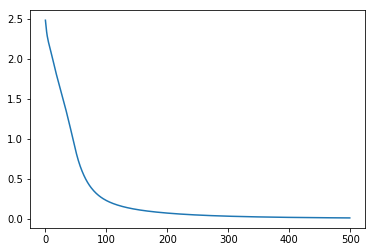

In [5]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.plot(losses)

In [7]:
"""
toメソッドでGPUに転送
"""
X = X.to("cuda:0")
Y = Y.to("cuda:0")
net.to("cuda:0")

optimizer = optim.Adam(net.parameters())

losses = []

for epoc in range(500):
    optimizer.zero_grad()
    y_pred = net(X)
    loss = loss_fn(y_pred, Y)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

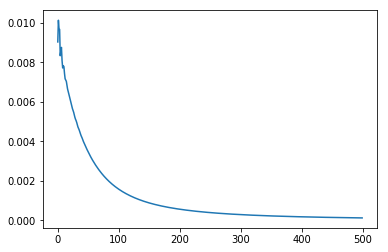

In [8]:
plt.plot(losses)

DatasetとDataLoader

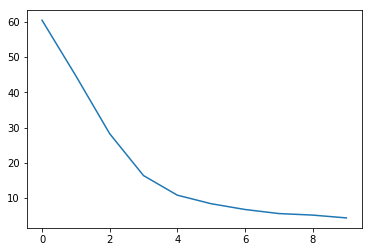

In [13]:
from torch.utils.data import TensorDataset, DataLoader

X = digits.data
Y = digits.target

# NumPyのndarrayをPyTorchのTensorに変換
X = torch.tensor(X, dtype=torch.float32)
Y = torch.tensor(Y, dtype=torch.int64)

# Datasetを作成
ds = TensorDataset(X, Y)

# 異なる順番で64個ずつデータを返すDataLoaderを作成
loader = DataLoader(ds, batch_size=64, shuffle=True)

net = nn.Sequential(
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 16),
    nn.ReLU(),
    nn.Linear(16, 10)
)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

# 最適化を実行
losses = []
for epoc in range(10):
    running_loss = 0.0
    for xx, yy in loader:
        # xx, yyは64個分のみ受け取れる
        y_pred = net(xx)
        loss = loss_fn(y_pred, yy)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    losses.append(running_loss)
plt.plot(losses)

In [17]:
"""
より深くしたコード①
"""
# データを訓練用と検証用に分割
from sklearn.model_selection import train_test_split
# 全体の30%は検証用
X = digits.data
Y = digits.target
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.3
)
X_train = torch.tensor(X_train, dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.int64)
X_test = torch.tensor(X_test, dtype=torch.float32)
Y_test = torch.tensor(Y_test, dtype=torch.int64)

# 層を積み重ねて深いニューラルネットワークを構築する
k = 100
net = nn.Sequential(
    nn.Linear(64, k),
    nn.ReLU(),
    nn.Linear(k, k),
    nn.ReLU(),
    nn.Linear(k, k),
    nn.ReLU(),
    nn.Linear(k, k),
    nn.ReLU(),
    nn.Linear(k, 10)
)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())
# 訓練用データでDataLoaderを作成
ds = TensorDataset(X_train, Y_train)
loader = DataLoader(ds, batch_size=32, shuffle=True)

In [16]:
"""
より深くしたコード②
"""
train_losses = []
test_losses = []
for epoc in range(100):
    running_loss = 0.0
    for i, (xx, yy) in enumerate(loader):
        y_pred = net(xx)
        loss = loss_fn(y_pred, yy)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / i)
    y_pred = net(X_test)
    test_loss = loss_fn(y_pred, Y_test)
    test_losses.append(test_loss.item())

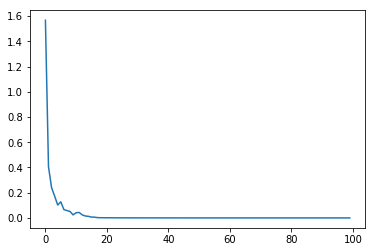

In [21]:
plt.plot(train_losses)

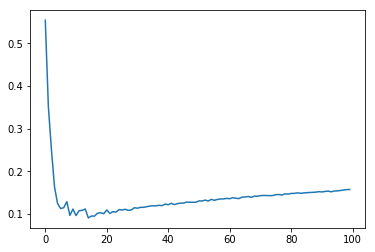

In [23]:
plt.plot(test_losses)

In [25]:
"""
trainとevalメソッドでDropoutの挙動を切り替える①
"""
# 確率0.5でランダムに変数の次元を捨てるDropoutを各層に追加
net = nn.Sequential(
    nn.Linear(64, k),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(k, k),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(k, k),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(k, k),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(k, 10)
)

In [27]:
"""
trainとevalメソッドでDropoutの挙動を切り替える②
"""
optimizer = optim.Adam(net.parameters())

train_losses = []
test_losses = []
for epoc in range(100):
    running_loss = 0.0
    # ネットワークを訓練モードにする
    net.train()
    for i, (xx, yy) in enumerate(loader):
        y_pred = net(xx)
        loss = loss_fn(y_pred, yy)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / i)
    # ネットワークを評価モードにして検証データの損失関数を計算する
    net.eval()
    y_pred = net(X_test)
    test_loss = loss_fn(y_pred, Y_test)
    test_losses.append(test_loss.item())

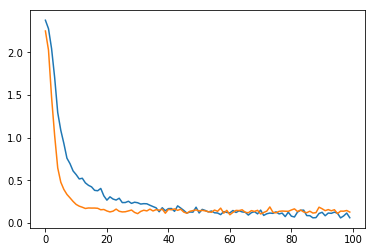

In [28]:
plt.plot(train_losses)
plt.plot(test_losses)

Batch Normalizationによる学習の加速

In [29]:
# Linear層にはBatchnorm1dを適用する
net = nn.Sequential(
    nn.Linear(64, k),
    nn.ReLU(),
    nn.BatchNorm1d(k),
    nn.Linear(k, k),
    nn.ReLU(),
    nn.BatchNorm1d(k),
    nn.Linear(k, k),
    nn.ReLU(),
    nn.BatchNorm1d(k),
    nn.Linear(k, k),
    nn.ReLU(),
    nn.BatchNorm1d(k),
    nn.Linear(k, 10)
)

独自のネットワーク層（カスタム層）を作る

In [30]:
"""
活性化関数ReLUとDropoutを含んだカスタムの線形層を作り、それを用いてMLPを記述
"""
class CustomLinear(nn.Module):
    def __init__(self, in_features, out_features, bias=True, p=0.5):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features, bias)
        self.relu = nn.ReLU()
        self.drop = nn.Dropout(p)
        
        def forward(self, x):
            x = self.linear(x)
            x = self.relu(x)
            x = self.drop(x)
            return x
    
mlp = nn.Sequential(
    CustomLinear(64, 200),
    CustomLinear(200, 200),
    CustomLinear(200, 200),
    nn.Linear(200, 10)
)

In [32]:
"""
nn.Moduleを継承したクラスの利用
"""
class MyMLP(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.ln1 = CustomLinear(in_features, 200)
        self.ln2 = CustomLinear(200, 200)
        self.ln3 = CustomLinear(200, 200)
        self.ln4 = CustomLinear(200, out_features)
    
    def forward(self, x):
        x = self.ln1(x)
        x = self.ln2(x)
        x = self.ln3(x)
        x = self.ln4(x)
        return x

mlp = MyMLP(64, 10)